# MODELADO Holt-Winters (SES)

## 1. Cargar serie de tiempo

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing

serie = pd.read_csv("../data/processed/serie_preparada.csv", index_col=0, parse_dates=True)
metrica = "total_pkts"
plt.style.use("seaborn-v0_8")
#Asegurar que la columna de la serie temporal es numerica y no datetime
serie[metrica] = pd.to_numeric(serie[metrica], errors="coerce")

# Se agrega la frecuencia para filtrar warning
freq = pd.infer_freq(serie.index)
print("Frecuencia inferida:", freq)

if freq is not None:
    serie = serie.asfreq(freq)
    serie.index.freq = freq
serie.info()

Frecuencia inferida: min
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Freq: min
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_pkts  93 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


## 2. Seleccionar ventana benigna


Rango temporal de la Ventana benigna (Tráfico Normal)
2017-07-07 03:30:00 -> 2017-07-07 03:55:00 n =  26

Observaciones de entrenamiento (benignas):  26
Observaciones restantes (validación + ataque):  66



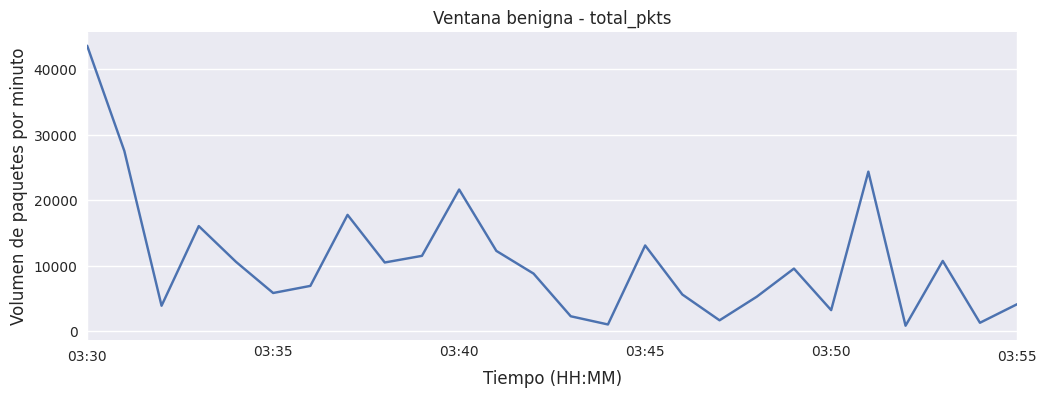

In [43]:
# Marca de cuando inicia el ataque DDoS en el dataset
inicio_ataque = pd.Timestamp("2017-07-07 03:56:00")

# Serie completa
serie_full = serie[metrica].copy()

# Serie de entrenamiento - Tráfico Normal
serie_train = serie_full[serie_full.index < inicio_ataque].copy()
print("\n" + "="*60)
print("Rango temporal de la Ventana benigna (Tráfico Normal)")
print(serie_train.index.min(), "->", serie_train.index.max(), "n = ", len(serie_train))
print("\n" + "="*60)
print("Observaciones de entrenamiento (benignas): ",len(serie_train))
print("Observaciones restantes (validación + ataque): ",len(serie_full[serie_full.index > inicio_ataque]))
print("\n" + "="*60)

plt.figure(figsize=(12,4))
serie_train.plot()
plt.title("Ventana benigna - total_pkts")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.show()

## 3. Ajustar Holt-Winters (SES)

In [44]:
modelo_ses = ExponentialSmoothing(serie_train, trend=None, seasonal=None)
modelo_ses = modelo_ses.fit()
print(modelo_ses.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               total_pkts   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                     2309457682.732
Optimized:                         True   AIC                            479.857
Trend:                             None   BIC                            482.373
Seasonal:                          None   AICC                           481.761
Seasonal Periods:                  None   Date:                 Mon, 08 Dec 2025
Box-Cox:                          False   Time:                         06:48:08
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2842876                alpha                 True
initial_level              22870.1

## 4. Predicción (IN-SAMPLE + OUT-OF-SAMPLE)

### 4.1 Predicción IN-SAMPLE

In [45]:
# Generar predicciones dentro de la ventana benigna (IN-SAMPLE)
pred_train_ses = modelo_ses.fittedvalues
pred_train_ses.head()

timestamp
2017-07-07 03:30:00    22870.115921
2017-07-07 03:31:00    28758.532249
2017-07-07 03:32:00    28405.580012
2017-07-07 03:33:00    21438.662931
2017-07-07 03:34:00    19908.438547
Freq: min, dtype: float64

### 4.2 Predicciones OUT-OF-SAMPLE


In [46]:
# Generar predicciones desde el ataque en adelante (OUT-OF-SAMPLE)
n_full = len(serie_full)
n_train = len(serie_train)
n_out = n_full - n_train

pred_out_ses = modelo_ses.forecast(steps=n_out)
pred_out_ses.head()

2017-07-07 03:56:00    6018.881961
2017-07-07 03:57:00    6018.881961
2017-07-07 03:58:00    6018.881961
2017-07-07 03:59:00    6018.881961
2017-07-07 04:00:00    6018.881961
Freq: min, dtype: float64

### 4.3 Unificar

Gráfico exportado exitosamente a:  ../results/18_Prediccion_Holt_Winters_SES_Serie_Completa.png


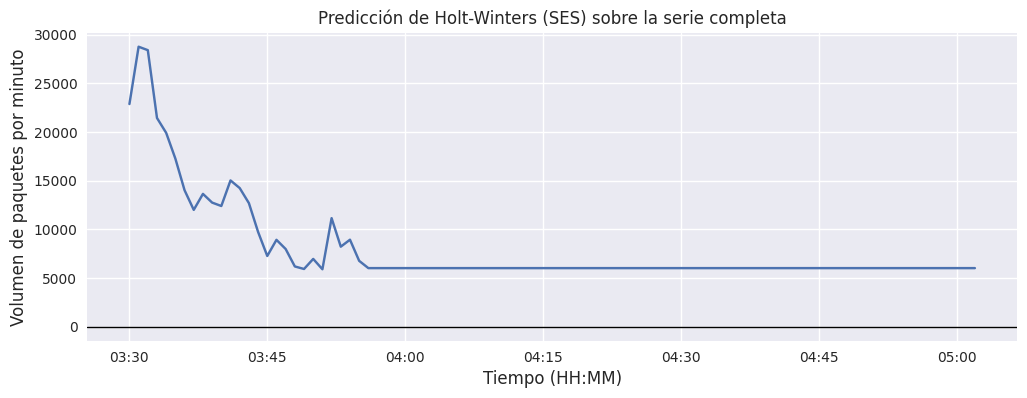

In [47]:
pred_full_ses = pd.concat([pred_train_ses, pred_out_ses])
pred_full_ses.index = serie_full.index
pred_full_ses.name = "pred_ses"

plt.figure(figsize=(12,4))
plt.plot(pred_full_ses)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Predicción de Holt-Winters (SES) sobre la serie completa")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.axhline(0,color='black', linewidth=1)

# Exportar el gráfico
ruta = "../results/18_Prediccion_Holt_Winters_SES_Serie_Completa.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

## 5. Calcular Residuos Holt-Winters (SES)

Gráfico exportado exitosamente a:  ../results/19_Paquetes_Minuto_Holt_Winters_SES_Residuo.png


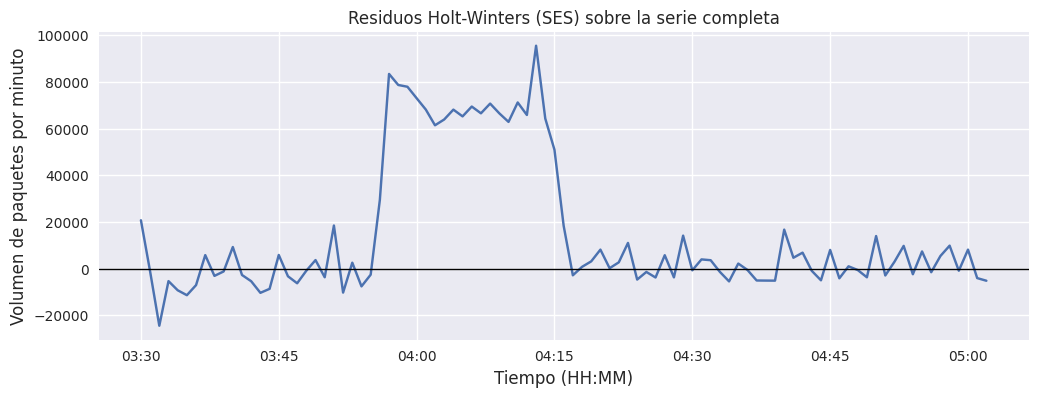

In [48]:
residuos_ses = serie_full - pred_full_ses

plt.figure(figsize=(12,4))
plt.plot(residuos_ses)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Residuos Holt-Winters (SES) sobre la serie completa")
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.axhline(0, color='black', linewidth=1)
# Exportar el gráfico
ruta = "../results/19_Paquetes_Minuto_Holt_Winters_SES_Residuo.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

## 6. Exportar residuos Holt-Winters (SES)

In [49]:
df_residuos_ses = pd.DataFrame({"residuos_hw_ses":residuos_ses})
df_residuos_ses.to_csv("../data/processed/residuos_hw_ses.csv")
print("Archivo Generado: ../data/residuos_hw_ses.csv")

Archivo Generado: ../data/residuos_hw_ses.csv
